# 1. Regression

## 1.1. Load Data and Train Model

# SHAP Metrics

In [2]:
from sklearn.linear_model import LinearRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import mean_squared_error

dataset = load_dataset('us_crime')
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['train']
test = dataset['test']

model = LinearRegression()
model.fit(train['X'], train['y'])

mean_squared_error(test['y'], model.predict(test['X']))

np.float64(0.01902558611293644)

# Create a Custom Feature Importance Calculator

In [4]:
from holisticai.utils import RegressionProxy
from holisticai.utils.feature_importances import compute_shap_feature_importance
from holisticai.utils.inspection import compute_partial_dependence

proxy = RegressionProxy(predict=model.predict)

local_importances = compute_shap_feature_importance(X=test['X'], y=test['y'], proxy=proxy, max_samples=200)
local_conditional_importances = local_importances.conditional()

importances = local_importances.to_global()
conditional_importances = local_conditional_importances.to_global()

ranked_importances = importances.top_alpha(0.8)

partial_dependencies = compute_partial_dependence(test['X'], features=ranked_importances.feature_names, proxy=proxy)

y_pred = proxy.predict(test['X'])

In [5]:
from holisticai.explainability.metrics import regression_explainability_metrics

regression_explainability_metrics(importances, partial_dependencies, conditional_importances, test['X'], y_pred, local_importances)

,metric,value,reference
0,Alpha Importance Score,0.376238,0.0
1,XAI Ease Score,1.000000,1.0
2,Position Parity,0.266532,1.0
3,Rank Alignment,0.901885,1.0
4,Spread Ratio,0.879179,0.0
5,Spread Divergence,0.557938,0.0
6,Data Stability,0.967738,1.0
7,Feature Stability,0.969185,1.0


<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

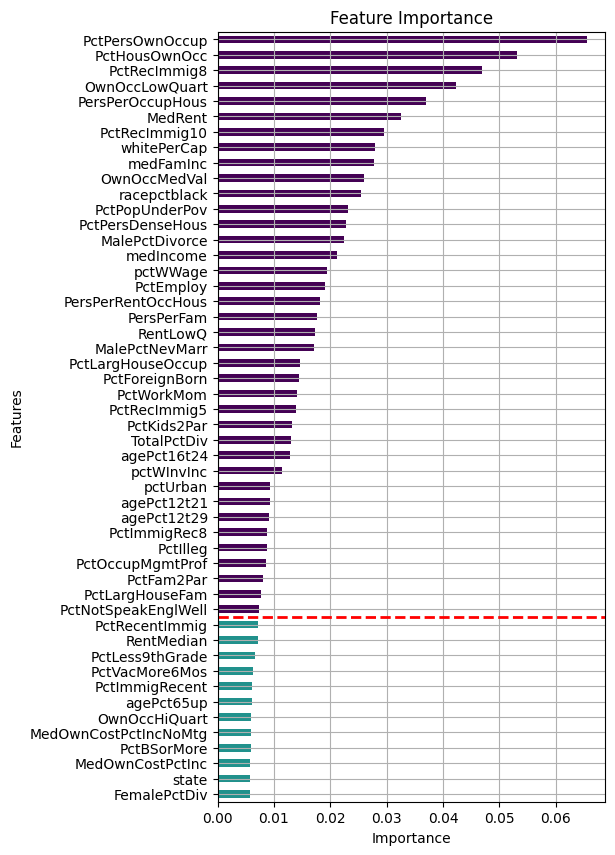

In [6]:
from holisticai.explainability.plots import plot_feature_importance
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1, figsize=(5,10))
plot_feature_importance(importances, top_n=50, ax=ax)

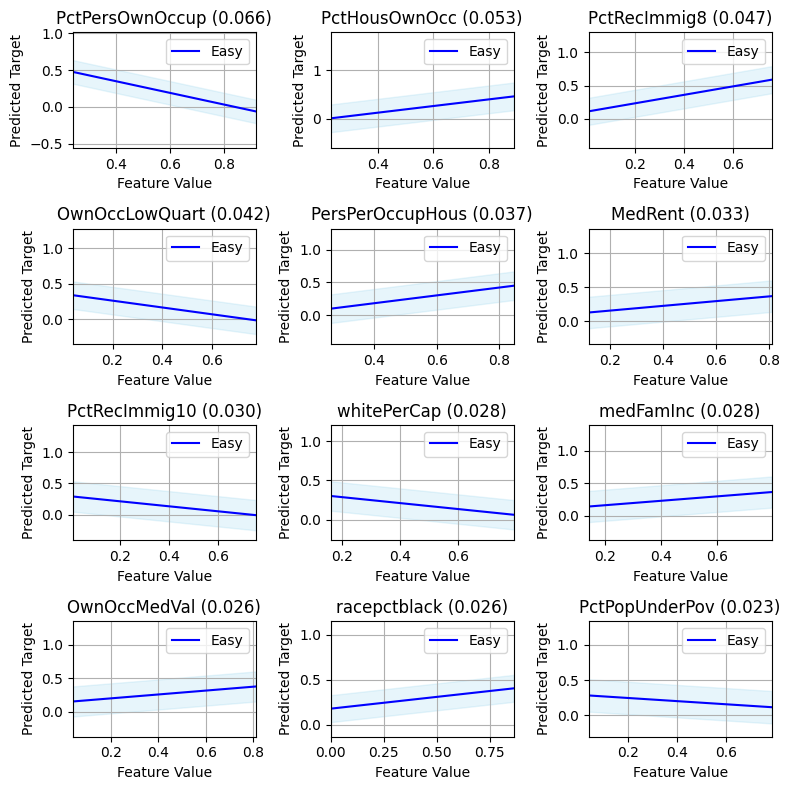

In [7]:
from holisticai.explainability.plots import plot_partial_dependence

plot_partial_dependence(partial_dependencies, ranked_importances, subplots=(4,3), figsize=(8, 8))

# 3. Classification

In [8]:
from sklearn.linear_model import LogisticRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score

dataset = load_dataset('adult')
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['train']
test = dataset['test']

model = LogisticRegression()
model.fit(train['X'], train['y'])

accuracy_score(test['y'], model.predict(test['X']))

0.7955776672194582

In [15]:
from holisticai.utils import BinaryClassificationProxy
from holisticai.utils.feature_importances import compute_shap_feature_importance
from holisticai.utils.inspection import compute_partial_dependence

proxy = BinaryClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)

local_importances = compute_shap_feature_importance(X=test['X'], y=test['y'], proxy=proxy, max_samples=200)
local_conditional_importances = local_importances.conditional()

importances = local_importances.to_global()
conditional_importances = local_conditional_importances.to_global()

ranked_importances = importances.top_alpha(0.8)

partial_dependencies = compute_partial_dependence(test['X'], features=ranked_importances.feature_names, proxy=proxy)

y_pred = proxy.predict(test['X'])

In [16]:
from holisticai.explainability.metrics import classification_explainability_metrics

classification_explainability_metrics(importances, partial_dependencies, conditional_importances, test['X'], y_pred, local_importances)

,metric,value,reference
0,Alpha Importance Score,0.010309,0.0
1,XAI Ease Score,0.750000,1.0
2,Position Parity,1.000000,1.0
3,Rank Alignment,1.000000,1.0
4,Spread Ratio,0.212011,0.0
5,Spread Divergence,0.070706,0.0
6,Data Stability,0.922200,1.0
7,Feature Stability,0.181205,1.0


<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

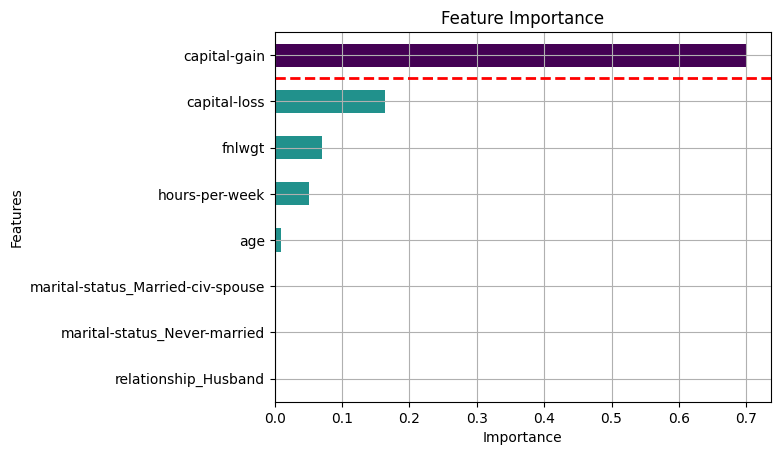

In [17]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(importances, top_n=8)

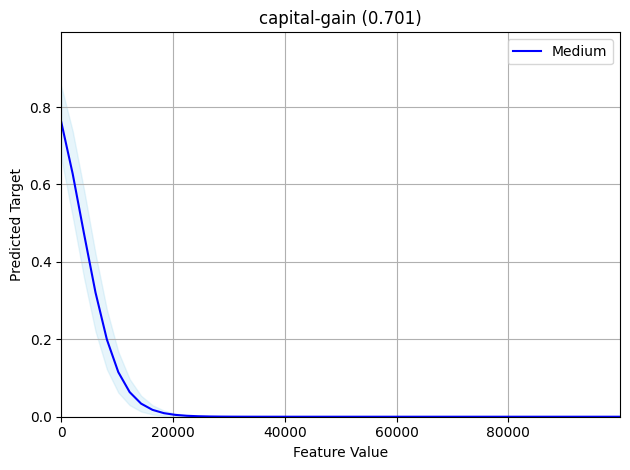

In [18]:
from holisticai.explainability.plots import plot_partial_dependence

class_index = 0 #1
plot_partial_dependence(partial_dependencies[class_index], ranked_importances)

# Multi Classification

In [19]:
from sklearn.linear_model import LogisticRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score

dataset = load_dataset(dataset_name="student_multiclass")
dataset = dataset.train_test_split(test_size=0.2, random_state=42)
train = dataset['train']
test = dataset['test']

model = LogisticRegression()
model.fit(train['X'], train['y'])

accuracy_score(test['y'], model.predict(test['X']))

0.5063291139240507

In [20]:
from holisticai.utils import MultiClassificationProxy
from holisticai.utils.feature_importances import compute_shap_feature_importance
from holisticai.utils.inspection import compute_partial_dependence

proxy = MultiClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)

local_importances = compute_shap_feature_importance(X=train['X'], y=train['y'], proxy=proxy, max_samples=200)
local_conditional_importances = local_importances.conditional()

importances = local_importances.to_global()
conditional_importances = local_conditional_importances.to_global()

ranked_importances = importances.top_alpha(0.8)

partial_dependencies = compute_partial_dependence(test['X'], features=ranked_importances.feature_names, proxy=proxy)

y_pred = proxy.predict(test['X'])

In [21]:
from holisticai.explainability.metrics import multiclass_explainability_metrics

multiclass_explainability_metrics(importances, partial_dependencies, conditional_importances, test['X'], y_pred, local_importances)

,metric,value,reference
0,Alpha Importance Score,0.461538,0.0
1,XAI Ease Score,1.000000,1.0
2,Position Parity,0.712196,1.0
3,Rank Alignment,0.923299,1.0
4,Spread Ratio,0.891234,0.0
5,Spread Divergence,0.641625,0.0
6,Data Stability,0.963793,1.0
7,Feature Stability,0.937159,1.0


<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

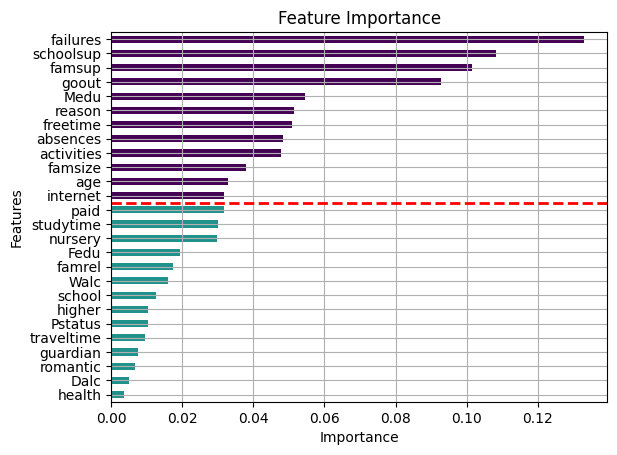

In [22]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(importances, top_n=30)

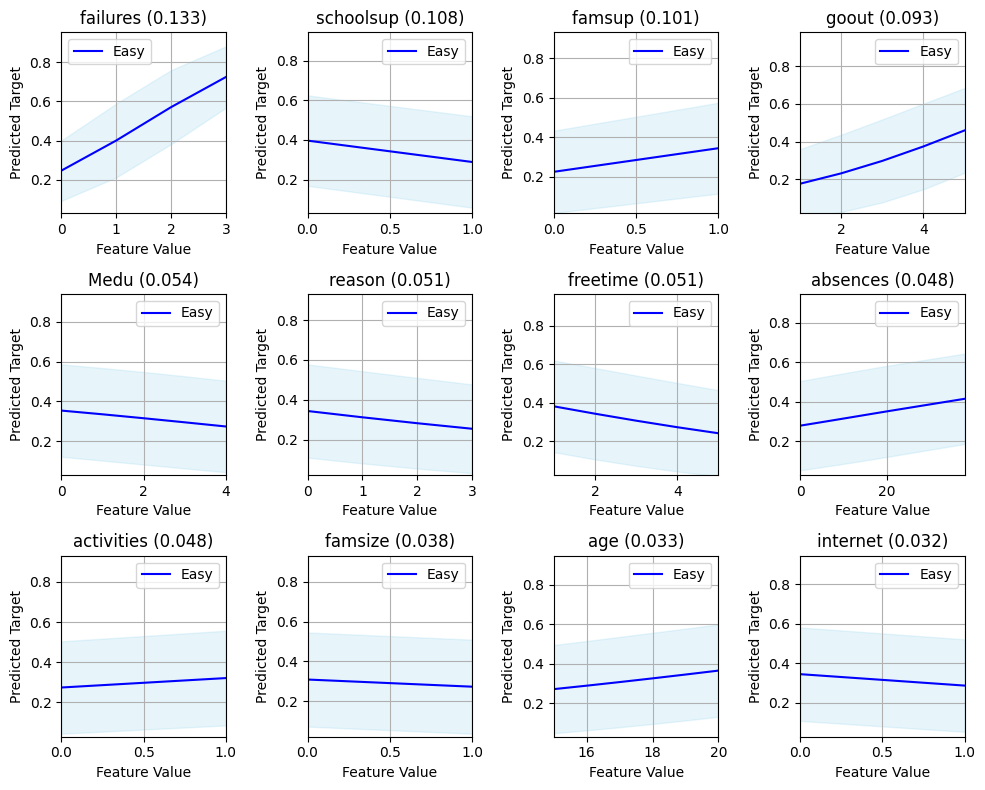

In [23]:
from holisticai.explainability.plots import plot_partial_dependence

class_index = 0 #1
plot_partial_dependence(partial_dependencies[class_index], ranked_importances, subplots=(3,4), figsize=(10,8))